Part 1

For this part of the assignment, we should extend the sample kernel of the RBF evaluation to a more general case: when the number of sources (nsources) is large. Each threadblock in the sample RBF kernel was assigned with (16 x nsources) threads. If (16 x nsources) > 1024, which is beyond the thread limit in CUDA, the sample kernel will encounter a failure.

To get rid of this limit, it is straightforward to split the sources into different blocks, in the same way we spliting the targets. In this part of the assignment, we will adjust the sample kernel so that is compatible with a manually determined threadblocks size of 16*32. 

Some of the initial settings and customer functions are included in the next code section.

In [1]:
import math
import numpy as np 
import numba
from numba import cuda
import time

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

# timer class is used to measure the time performance of our algorithm
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

# pts_generator (points generator) is used to generate a set of source points and their corresponding weights, such sources are picked randomly over plan xy, xz, yz. The random seed(0) is selected for the purpose of reproducibility.
def pts_generator(npoints, nsources):
    # generate indices on xy, xz, yz plane
    plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]

    targets_xy = np.vstack((plot_grid[0].ravel(),
                            plot_grid[1].ravel(),
                            np.zeros(plot_grid[0].size))).T
    targets_xz = np.vstack((plot_grid[0].ravel(),
                            np.zeros(plot_grid[0].size),
                            plot_grid[1].ravel())).T
    targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                        plot_grid[0].ravel(),
                        plot_grid[1].ravel())).T

    targets = np.vstack((targets_xy, targets_xz, targets_yz))

    # random seed
    rand = np.random.RandomState(0)

    # picking random sources
    sources = rand.rand(nsources, 3)

    # generate random weights
    weights = rand.rand(len(sources))
    return targets, sources, weights


def visualize(result, npoints):
    # A helper function for visualization
    
    result_xy = result[: npoints * npoints].reshape(npoints, npoints).T
    result_xz = result[npoints * npoints : 2 * npoints * npoints].reshape(npoints, npoints).T
    result_yz = result[2 * npoints * npoints:].reshape(npoints, npoints).T

    fig = plt.figure(figsize=(20, 20))    

    ax = fig.add_subplot(1, 3, 1)   
    _ = ax.imshow(result_xy, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 2)   
    _ = ax.imshow(result_xz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    ax = fig.add_subplot(1, 3, 3)   
    _ = ax.imshow(result_yz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('y')
    ax.set_ylabel('z')

# the Python Numba implementation, which will be used as a performance benchmark compared to the CUDA method
@numba.njit(parallel=True)
def rbf_evaluation_python(sources, targets, weights, result):
    """Evaluate the RBF sum."""
    
    n = len(sources)
    m = len(targets)
        
    result[:] = 0
    for index in numba.prange(m):
        result[index] = np.sum(np.exp(-np.sum(np.abs(targets[index] - sources)**2, axis=1) / (2 * sigma**2)) * weights)

In the preliminary attemps, we will set $\sigma = 0.1$ and each axis is splited into 200 points and therefore 40000 target points over each plane. 800 randomly picked source points are also generated on the plane. We split targets into a group of 16 and sources into a group of 32. Then the threadblock has size (16, 32).

In [2]:
# external configuration
sigma = .1
npoints = 200
nsources = 800
# data based on sources and targets
targets, sources, weights = pts_generator(npoints, nsources)
ntargets = targets.shape[0]

# equivalent
SX = 16
SY = 32

# calculate the size of grid [row_blocks, col_blocks]
row_blocks = math.ceil(ntargets / SX)
col_blocks = math.ceil(nsources / SY)


With these initial settings, we are ready to construct the new kernel. The new calculation will have following stages:
* sources and targets indices will be transfered into CUDA memory (outside the kernel)
* each threadblock contains a local intermediate array of size (ntargets, number of blocks column)
* threadblocks evalute the RBF result of each target and store into in the corresponding position in the intermediate array (done in rbf_evaluation_cuda_temp kernel)
* a second kernel (result_temp_sum) will be used to sum the interdiate array and store into a result array of dimension ntargets
* return the result back to the CPU


In [3]:
# local RBF kernel
@cuda.jit
def rbf_evaluation_cuda_temp(sources, targets, weights, result_temp):
    local_result = cuda.shared.array((SX, SY), numba.float32)
    local_targets = cuda.shared.array((SX, 3), numba.float32)
    local_sources = cuda.shared.array((SY, 3), numba.float32)
    local_weights = cuda.shared.array(SY, numba.float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    by = cuda.blockIdx.y

    px, py = cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    # At first we are loading all the targets into the shared memory
    # We use only the first column of threads to do this.
    
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading all the sources and weights.
    # We only require the first row of threads to do this.
    
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        # setting corresponding weights
        local_weights[ty] = weights[py]
        
    # Let us now sync all threads
    # this mean we wait for all previous kernel launches to finish executing
    cuda.syncthreads()
    
    # Now compute the interactions
    
    squared_diff = numba.float32(0)
    
    for index in range(3):
        squared_diff += (local_targets[tx, index] - local_sources[ty, index])**2
    local_result[tx, ty] = math.exp(-squared_diff / ( numba.float32(2) * numba.float32(sigma)**2)) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results
    
    if ty == 0:
        res = numba.float32(0)
        for index in range(SY):
            res += local_result[tx, index]
        # store into the corresponding position intermediate array
        result_temp[px, by] = res
       
# summation kernel, each block has only one thread, we will have ntarget number of blocks.
@cuda.jit
def result_temp_sum(result_temp, result):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    px, _ = cuda.grid(2)
    # we just need the first col to do the summation
    if ty == 0:
        res = numba.float32(0)
        for index in range(col_blocks):
            res += result_temp[px, index]
    result[px] = res

data transfer takes 0.08477258682250977 seconds
calculation takes 0.5475366115570068 seconds
data transfer back takes 0.0009970664978027344 seconds
[0.36831468 0.39154625 0.41591936 0.44146854 0.46822703 0.49622577
 0.5254933  0.55605453 0.587931   0.6211392  0.65569115 0.6915926
 0.72884303 0.7674349  0.8073531  0.84857416 0.89106536 0.93478507
 0.97968143 1.025693   1.0727472  1.1207612  1.1696407  1.2192817
 1.2695686  1.3203763  1.3715684  1.4230018  1.474521   1.5259662
 1.5771681  1.6279533  1.6781428  1.7275553  1.7760057  1.8233119
 1.8692908  1.9137625  1.9565523  1.997492   2.0364215  2.0731897
 2.1076584  2.139701   2.1692061  2.1960773  2.2202368  2.241621
 2.2601888  2.2759168 ]


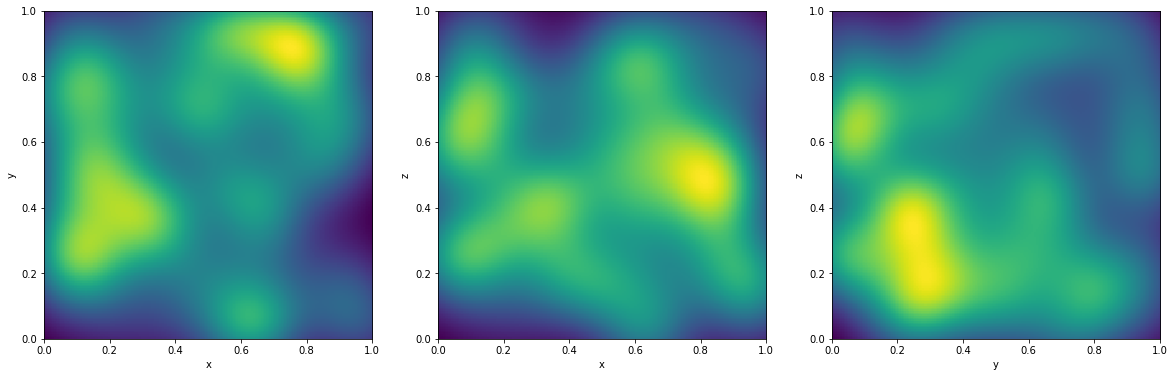

In [4]:
# in this implementation we use result_temp as an intermediate storage of the each local result


# timer for data transfer process
with Timer() as t_data:
    result_temp = numba.cuda.device_array((ntargets, col_blocks), dtype=np.float32)
    result_cuda = numba.cuda.device_array(ntargets, dtype=np.float32)
    targets_cuda = numba.cuda.to_device(targets)
    sources_cuda = numba.cuda.to_device(sources)
    weights_cuda = numba.cuda.to_device(weights)
print("data transfer takes {t} seconds".format(t=t_data.interval))

# timer for kernel calculation
with Timer() as t_cal:
    rbf_evaluation_cuda_temp[(row_blocks, col_blocks), (SX, SY)](sources_cuda, targets_cuda, weights_cuda, result_temp)
    #result_temp = result_temp.copy_to_host()
    #result = np.sum(result_temp, axis=1)
    result_temp_sum[(ntargets, 1), (1, 1)](result_temp, result_cuda)
print("calculation takes {t} seconds".format(t=t_cal.interval))

with Timer() as t_back:
    result_cuda = result_cuda.copy_to_host()
print("data transfer back takes {t} seconds".format(t=t_back.interval))



%matplotlib inline
visualize(result_cuda, npoints)
print(result_cuda[0:50])

## this part of code is used to clear the device memory. Method numba.cuda.cudadrv.driver.Device.reser() provided by numba 0.52 documentation does not work in lower numba version. Code below is for everyone's interest.
result_temp = result_temp.copy_to_host()
weights_cuda = weights_cuda.copy_to_host()
sources_cuda = sources_cuda.copy_to_host()
targets_cuda = targets_cuda.copy_to_host()

The above code shows how we could use our modified kernel to produce the result. 
Please notice that the calculation time is abnormally long. This is because the first time execution involves the compilation time for numba. Just do not take it seriously in this section. We will do a formal performance benchmark later.

python Numba method takes seconds
[0.36831455 0.39154624 0.41591928 0.44146846 0.46822693 0.49622574
 0.52549322 0.55605451 0.58793088 0.62113915 0.65569102 0.69159243
 0.7288429  0.76743487 0.8073531  0.84857402 0.89106521 0.93478488
 0.97968139 1.02569291 1.07274709 1.12076092 1.16964057 1.21928148
 1.26956844 1.32037595 1.37156853 1.42300138 1.47452096 1.52596592
 1.57716798 1.6279531  1.67814265 1.72755477 1.77600585 1.82331197
 1.86929062 1.91376228 1.95655214 1.99749184 2.03642114 2.0731896
 2.10765821 2.1397009  2.169206   2.1960775  2.22023625 2.24162091
 2.26018876 2.27591627]


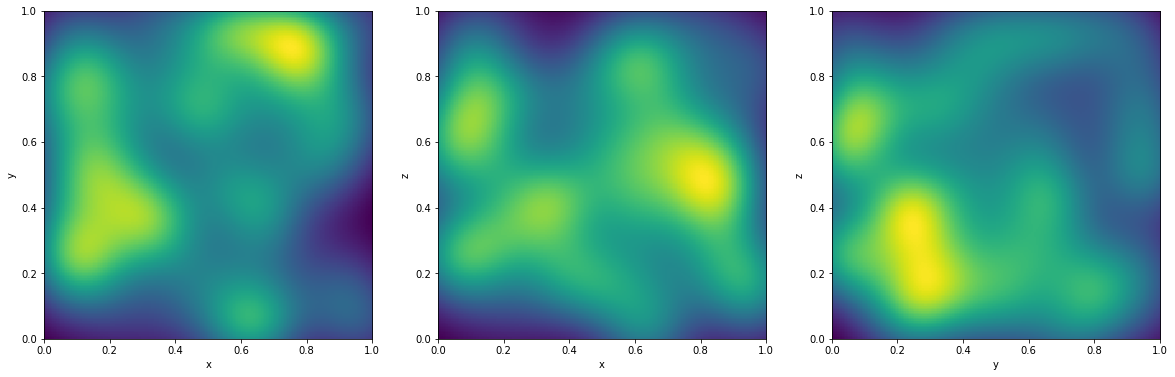

In [5]:
result_python = np.zeros(len(targets), dtype=np.float64)
with Timer() as t_python:
    rbf_evaluation_python(sources, targets, weights, result_python)
print("python Numba method takes seconds".format(t_python.interval))
visualize(result_python, npoints)

print(result_python[0:50])

We can easily verity the our result between the python numba and CUDA method by taking the max difference in the results. Simply by observing the printed output above, we can estimaten the difference is about $1E-7$.

In [6]:
err = np.max(abs(result_cuda-result_python))
print("maximum difference is {err}".format(err=err))

maximum difference is 2.3873729162460222e-06


The minimum decimal value in single-precision floating-point is $2^{-23} \approx 1E-7$. Thus, accuracy of our CUDA algorithm is up to single precision.

Finally we are ready to test the CUDA algorithm with a sufficient large amount of sources and targets and benchmark its performance. We will keep one of npoints or nsources unchanged and change the other.

As for my understand, increasing npoints or nsources will not influence the calculation data if the algorithm is perfectly paralleled, without consedering the cost of tread creating.

data transfer takes, 0.00399 seconds, ntargets = 120000, nsource = 200
calculation takes, 0.001024723052979 seconds, ntarget = 120000, nsource = 200
data transfer back takes, 0.003985881805420 seconds, ntarget = 120000, nsource = 200
data transfer takes, 0.00299 seconds, ntargets = 120000, nsource = 400
calculation takes, 0.001024007797241 seconds, ntarget = 120000, nsource = 400
data transfer back takes, 0.005957126617432 seconds, ntarget = 120000, nsource = 400
data transfer takes, 0.00399 seconds, ntargets = 120000, nsource = 600
calculation takes, 0.000000000000000 seconds, ntarget = 120000, nsource = 600
data transfer back takes, 0.007005214691162 seconds, ntarget = 120000, nsource = 600
data transfer takes, 0.00396 seconds, ntargets = 120000, nsource = 800
calculation takes, 0.000000000000000 seconds, ntarget = 120000, nsource = 800
data transfer back takes, 0.010972261428833 seconds, ntarget = 120000, nsource = 800
data transfer takes, 0.00456 seconds, ntargets = 120000, nsource

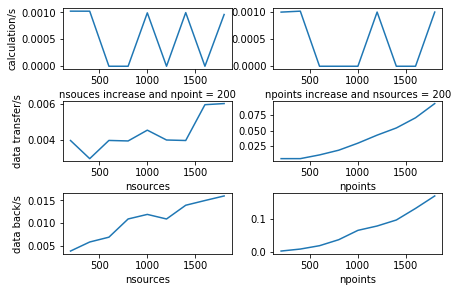

In [7]:
# external configuration
sigma = .1
###### in case the GPU memory is not enough to perform the higher limit 2000, just change it into some small value, like 800, the code is designed to work with varying limit (not recommanded)
lmt_l = 200
lmt_h = 2000
lmt_i = 200
size_test = [[lmt_l, temp] for temp in range(lmt_l,lmt_h,lmt_i)] + [[temp, lmt_l] for temp in range(lmt_l,lmt_h,lmt_i)]

rec = list()
for idx in range(len(size_test)):
    npoints = size_test[idx][0]
    nsources =size_test[idx][1]

    # data based on sources and targets
    targets, sources, weights = pts_generator(npoints, nsources)
    ntargets = targets.shape[0]

    SX = 16
    SY = 32

    # calculate the size of grid [row_blocks, col_blocks]
    row_blocks = math.ceil(ntargets / SX)
    col_blocks = math.ceil(nsources / SY)


    with Timer() as t_data:
        result_temp = numba.cuda.device_array((ntargets, col_blocks), dtype=np.float32)
        result_cuda = numba.cuda.device_array(ntargets, dtype=np.float32)
        targets_cuda = numba.cuda.to_device(targets)
        sources_cuda = numba.cuda.to_device(sources)
        weights_cuda = numba.cuda.to_device(weights)
    print("data transfer takes, {0:.5f} seconds, ntargets = {a}, nsource = {b}".format(t_data.interval,a=ntargets, b=nsources))

    with Timer() as t_cal:
        rbf_evaluation_cuda_temp[(row_blocks, col_blocks), (SX, SY)](sources_cuda, targets_cuda, weights_cuda, result_temp)
        #result_temp = result_temp.copy_to_host()
        #result = np.sum(result_temp, axis=1)
        result_temp_sum[(ntargets, 1), (1, 1)](result_temp, result_cuda)
    print("calculation takes, {0:.15f} seconds, ntarget = {a}, nsource = {b}".format(t_cal.interval,a=ntargets,b=nsources))

    with Timer() as t_back:
        result_cuda = result_cuda.copy_to_host()
    print("data transfer back takes, {0:.15f} seconds, ntarget = {a}, nsource = {b}".format(t_back.interval, a=ntargets, b=nsources))
    # %matplotlib inline
    # visualize(result_cuda, npoints)

    rec.append({"npoints":npoints, "ntargets":ntargets, "t_data":t_data.interval, "t_cal":t_cal.interval, "t_back":t_back.interval})
    ### clear ###
    result_temp = result_temp.copy_to_host()
    weights_cuda = weights_cuda.copy_to_host()
    sources_cuda = sources_cuda.copy_to_host()
    targets_cuda = targets_cuda.copy_to_host()

# plotting
mid = int((lmt_h-lmt_l)/lmt_i)
fig, _ = plt.subplots(3, 2)
fig.tight_layout() 
axs1 = plt.subplot(3, 2, 1)
axs1.plot([temp for temp in range(lmt_l, lmt_h, lmt_i)], [temp["t_cal"] for temp in rec[0:mid]])
axs1.set_xlabel("nsouces increase and npoint = 200")
axs1.set_ylabel("calculation/s")

axs2 = plt.subplot(3, 2, 2)
axs2.plot([temp for temp in range(lmt_l, lmt_h, lmt_i)], [temp["t_cal"] for temp in rec[mid::]])
axs2.set_xlabel("npoints increase and nsources = 200")

axs3 = plt.subplot(3, 2, 3)
axs3.plot([temp for temp in range(lmt_l, lmt_h, lmt_i)], [temp["t_data"] for temp in rec[0:mid]])
axs3.set_xlabel("nsources")
axs3.set_ylabel("data transfer/s")

axs4 = plt.subplot(3, 2, 4)
axs4.plot([temp for temp in range(lmt_l, lmt_h, lmt_i)], [temp["t_data"] for temp in rec[mid::]])
axs4.set_xlabel("npoints")

axs5 = plt.subplot(3, 2, 5)
axs5.plot([temp for temp in range(lmt_l, lmt_h, lmt_i)], [temp["t_back"] for temp in rec[0:mid]])
axs5.set_xlabel("nsources")
axs5.set_ylabel("data back/s")

axs6 = plt.subplot(3, 2, 6)
axs6.plot([temp for temp in range(lmt_l, lmt_h, lmt_i)], [temp["t_back"] for temp in rec[mid::]])
axs6.set_xlabel("npoints")
plt.show()

The figure (scroll down the above output to find it) above shows how the calculation/data transfer time changes with different npoints/nsources. As we expected, calculation time does not change significently if npoints or nsources increase. The algorighm is well paralleled.

The data transfer/back time does not change significently, but seems linearly, when n sources increase, since the sources have linear data movement complexity. (Actually, time needed for data back should not change when we change nsources and keep npoints constant. Because the size of back data does not change at all. I cannot explain why)

When npoints increase, the data transfer/back time increases quadraticlly, since ntarget = npoints**2, quadratic dependence. 

As n becomes larger, the data transfer part will take most of the time for the whole process.

data transfer takes  0.16755175590515137  seconds
calculation takes  0.0  seconds
data transfer back takes, 1.688572645187378 seconds, ntatget = 12000000, nsource = 2000
[0.43558303 0.43797612 0.44037858 0.4427905  0.44521177 0.4476425
 0.45008266 0.45253235 0.45499158 0.45746008 0.4599383  0.4624259
 0.46492308 0.46742982 0.46994615 0.47247192 0.47500747 0.47755253
 0.48010716 0.48267156 0.48524544 0.48782903 0.4904222  0.49302506
 0.49563774 0.49825993 0.5008919  0.50353354 0.50618494 0.508846
 0.51151687 0.51419747 0.5168877  0.51958793 0.5222978  0.5250174
 0.5277468  0.5304859  0.5332349  0.5359938  0.53876233 0.5415406
 0.5443288  0.54712677 0.54993445 0.55275214 0.55557954 0.5584167
 0.5612638  0.5641208 ]


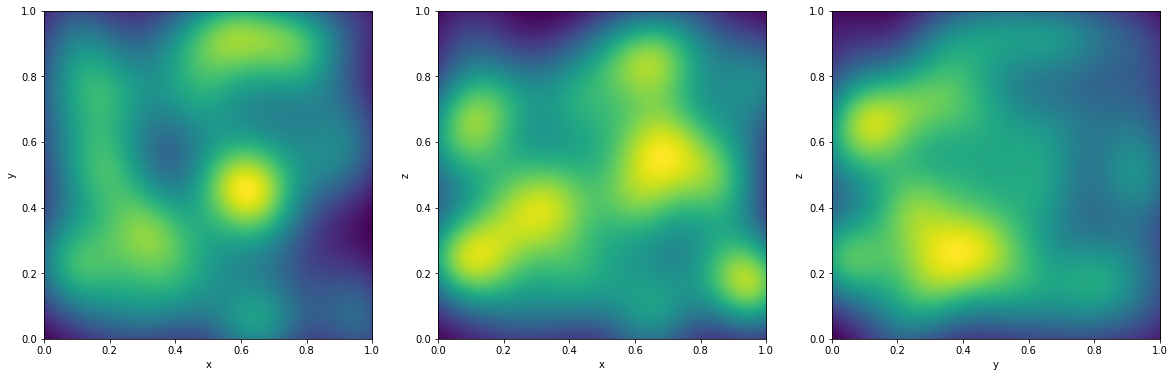

In [8]:
# external configuration
sigma = .1
npoints = 2000
nsources = 2000
# data based on sources and targets
targets, sources, weights = pts_generator(npoints, nsources)
ntargets = targets.shape[0]

# equivalent
SX = 16
SY = 32

# calculate the size of grid [row_blocks, col_blocks]
row_blocks = math.ceil(ntargets / SX)
col_blocks = math.ceil(nsources / SY)
# timer for data transfer process
with Timer() as t_data:
    result_temp = numba.cuda.device_array((ntargets, col_blocks), dtype=np.float32)
    result_cuda = numba.cuda.device_array(ntargets, dtype=np.float32)
    targets_cuda = numba.cuda.to_device(targets)
    sources_cuda = numba.cuda.to_device(sources)
    weights_cuda = numba.cuda.to_device(weights)
print("data transfer takes ", t_data.interval, " seconds")

# timer for kernel calculation
with Timer() as t_cal:
    rbf_evaluation_cuda_temp[(row_blocks, col_blocks), (SX, SY)](sources_cuda, targets_cuda, weights_cuda, result_temp)
    #result_temp = result_temp.copy_to_host()
    #result = np.sum(result_temp, axis=1)
    result_temp_sum[(ntargets, 1), (1, 1)](result_temp, result_cuda)
print("calculation takes ", t_cal.interval, " seconds")
with Timer() as t_back:
    result_cuda = result_cuda.copy_to_host()
print("data transfer back takes, {0:.15f} seconds, ntatget = {a}, nsource = {b}".format(t_back.interval, a=ntargets, b=nsources))

%matplotlib inline
visualize(result_cuda, npoints)
print(result_cuda[0:50])

## this part of code is used to clear the device memory. Method numba.cuda.cudadrv.driver.Device.reser() provided by numba 0.52 documentation does not work in lower numba version. Code below is for everyone's interest.
result_temp = result_temp.copy_to_host()
weights_cuda = weights_cuda.copy_to_host()
sources_cuda = sources_cuda.copy_to_host()
targets_cuda = targets_cuda.copy_to_host()

In my personal device, npoints = 2000, nsources = 2000 is the maximum input the kernel can take. Beyond which my GPU will run out of memory. The calculation time is still less than 0.01s.

Configured with identical setting, calculation without transferring data to device takes several seconds. Which is 5000 times slower than optimized method above.

calculation takes without data transfer to device in the first place 4.448376417160034  seconds


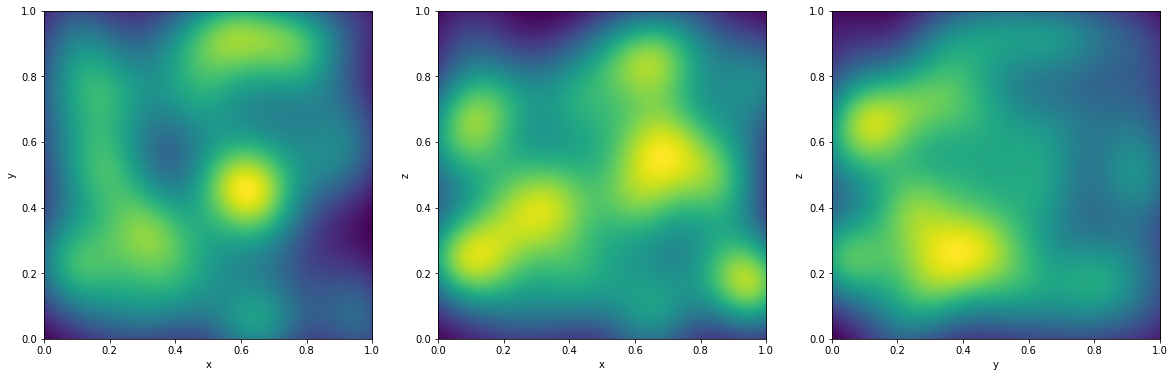

In [9]:
# external configuration
sigma = .1
npoints = 2000
nsources = 2000
# data based on sources and targets
targets, sources, weights = pts_generator(npoints, nsources)
ntargets = targets.shape[0]

# equivalent
SX = 16
SY = 32

# calculate the size of grid [row_blocks, col_blocks]
row_blocks = math.ceil(ntargets / SX)
col_blocks = math.ceil(nsources / SY)
# in this implementation we use result_temp as an intermediate storage of the each local result
with Timer() as t_cal:
    result_temp_CPU = np.zeros((ntargets, col_blocks), dtype=np.float32)
    result_CPU = np.zeros(ntargets, dtype=np.float32)
    rbf_evaluation_cuda_temp[(row_blocks, col_blocks), (SX, SY)](sources, targets, weights, result_temp_CPU)
    #result_temp = result_temp.copy_to_host()
    #result = np.sum(result_temp, axis=1)
    result_temp_sum[(ntargets, 1), (1, 1)](result_temp_CPU, result_CPU)
print("calculation takes without data transfer to device in the first place", t_cal.interval, " seconds")

visualize(result_CPU, npoints)


part 2

In this part of the assignment, we are required to design a CUDA accelerated kernal which could performs a equivalent mapping, as matrix A, of Laplace operator on an one-dimension array of $u_{i,j}$.

If the point is on the boundary/edge of the grid, the mapping will just keep its original value. If the point is inside the grid, an interior point, the mapping will perform like: $u_{i,j} \rightarrow \frac{4u_{i,j}-u_{i-1,j}-u_{i+1,j}-u_{i,j+1}}{h^2}$


This code section just contains some initial settings and a sample code which will be used to verify the realiability of out kernal.

In [10]:
import numpy as np
from scipy.sparse import coo_matrix
import numba
from numba import cuda
import time

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

# timer class is used to measure the time performance of our algorithm
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f



The kernal follows the stages:
* load the data into device
* within each thread check the position of point
* perform mapping (kernel)
* return the result

In [11]:
@cuda.jit
def mat_A_cuda(u, res):
    local_u = cuda.shared.array((SX, SY), numba.float64)

    px, py = cuda.grid(2)

    if px >= n or py >=  n:
        return
  
    #boundary case
    if px == 0 or px == n-1 or py == 0 or py == n-1:
        res[px*n+py]=u[px*n+py]
    #interior case
    else:
        res[px*n+py]=(n-1)**2*(4*u[px*n+py]-u[(px-1)*n+py]-u[(px+1)*n+py]-u[px*n+py+1]-u[px*n+py-1])


In [12]:
# we set the number of points over the grid is 200 along each axis
n = 200
# for the purpose of demonstration u is an array filled with random value with random seed 0
u = np.random.RandomState(0).rand(n*n).astype("float64")

SX = 32
SY = 32

block_rows = (n + 31) // SX
block_cols = (n + 31) // SY

# res = np.zeros(u.shape, dtype=np.float64)
res_cuda = numba.cuda.device_array(n*n, dtype=np.float64)
u_cuda = numba.cuda.to_device(u)


# the kernel has grid size [block_rows, block_cols], each block has size[SX, XY] 
mat_A_cuda[(block_rows, block_cols), (SX, SY)](u_cuda, res_cuda)
res_cuda = res_cuda.copy_to_host()

u_cuda = u_cuda.copy_to_host()

We can verify the correctness of our kernal just by comparing its output with the value of $A*u$ in which $A$ is the associated matrix generated for the possion problem.

In [13]:
A, _ = discretise_poisson(n)
u = np.random.RandomState(0).rand(n*n).astype("float64")
res_sample = A @ u
max_diff = np.max(abs(res_cuda - res_sample))
print("the maximum difference between CUDA and sample method is ", max_diff)

the maximum difference between CUDA and sample method is  5.820766091346741e-11


The difference is about $2^{-34}$ which lies between single and double precision.

or via a more formal/mathematical way

In [14]:
res_sample = A @ u
rel_error = np.linalg.norm(res_sample - res_cuda, np.inf) / np.linalg.norm(res_sample, np.inf)
print(f"Error: {round(rel_error, 2)}.")

Error: 0.0.


In [15]:

n = 200
# thread per grid
tpb = 1024
# number of block
nob = (len(u) + 1023) // 1024
rec = list()

# just change lim_h to a lower value if the current setting runs out of memory in your environment
lim_h = 12000
lim_l = 2000
lim_i = 2000

for n in range(lim_l, lim_h, lim_i):
    u = np.random.RandomState(0).rand(n*n).astype("float64")
    # res = np.zeros(u.shape, dtype=np.float64)
    print(n)
    with Timer() as t_data:
        u_cuda = numba.cuda.to_device(u)
        res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
    print("data transfer takes, {0:.5f} seconds, n = {a}".format(t_data.interval, a=n))
    with Timer() as t_cal:
        mat_A_cuda[nob, tpb](u_cuda, res_cuda)
    print("calculation takes, {0:.5f} seconds, n = {a}".format(t_cal.interval, a=n))
    with Timer() as t_back:
        res_cuda = res_cuda.copy_to_host()
    print("data back takes, {0:.5f} seconds, n = {a}".format(t_back.interval, a=n))
    u_cuda = u_cuda.copy_to_host()
    rec.append({"n":n,"t_data":t_data.interval,"t_cal":t_cal.interval, "t_back":t_back.interval})



2000
data transfer takes, 0.00898 seconds, n = 2000
calculation takes, 0.00100 seconds, n = 2000
data back takes, 0.00898 seconds, n = 2000
4000
data transfer takes, 0.03491 seconds, n = 4000
calculation takes, 0.00000 seconds, n = 4000
data back takes, 0.03787 seconds, n = 4000
6000
data transfer takes, 0.08277 seconds, n = 6000
calculation takes, 0.00000 seconds, n = 6000
data back takes, 0.08275 seconds, n = 6000
8000
data transfer takes, 0.15556 seconds, n = 8000
calculation takes, 0.00000 seconds, n = 8000
data back takes, 0.15624 seconds, n = 8000
10000
data transfer takes, 0.24995 seconds, n = 10000
calculation takes, 0.00000 seconds, n = 10000
data back takes, 0.24036 seconds, n = 10000


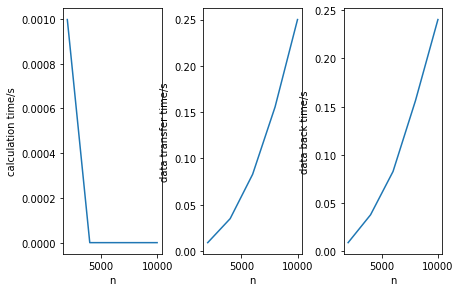

In [16]:
fig, _ = plt.subplots(1,3)
fig.tight_layout() 
axs1 = plt.subplot(1, 3, 1)
axs1.plot([temp["n"] for temp in rec], [temp["t_cal"] for temp in rec])
axs1.set_xlabel("n")
axs1.set_ylabel("calculation time/s")
axs2 = plt.subplot(1, 3, 2)
axs2.plot([temp["n"] for temp in rec], [temp["t_data"] for temp in rec])
axs2.set_xlabel("n")
axs2.set_ylabel("data transfer time/s")
axs3 = plt.subplot(1, 3, 3)
axs3.plot([temp["n"] for temp in rec], [temp["t_back"] for temp in rec])
axs3.set_xlabel("n")
axs3.set_ylabel("data back time/s")
plt.show()

The calculation time does not change significantly wrt n. There is a quadratic relationship between n and time for data transfer/back, which result from the fact that number of elements in u = $u^2$ 

Before we move on to the shared memory strategy. We would like to discuss the ratio of data movements to computations. It measures how efficiently we use the data. 

* data movement: For the kernel above, each thread (for the majority interior points) accesses the golbal memory 5 times to load the approximation by $u_{ij}$ and its adjacent points. There is a final store instruction to store the result of x into global memory. 

* computations: 4 floating point subtraction and 1 floating point multiplication are performed.

overall data movements/computations = 6/5

Our pervious kernal with 1d grid is (sadly) not intuitive for the shared memory strategy. It is better to redesign the kernal with 2D input.
* the shared memory is designed to be a (34, 34) matrix to contain all the information of u in local blocks and their adjacent points.
Thread in each block could only access the (34, 34) shared memory to calculate the linear map. Thus there is no need to continually access the slow global memory. However, since the shared memory stores duplicate datas, it might decrease the max n we could calculate.
The implementation of the shared memory method is as follows.

In [17]:
@cuda.jit
def mat_A_cuda_shared(u, res):
    local_u = cuda.shared.array((34, 34), numba.float64)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)

    if px>=n or py >=n:
        return

    local_u[tx+1, ty+1] = u[px, py]

    # transfer the u to a 34*34 shared memory local_u
    if tx == 0:
        #if px != 0: not necessary since thread will just do nothing if out of boundary
        local_u[tx, ty+1] = u[px-1, py]
    if tx == SX-1:
        #if px != n-1:
        local_u[tx+2, ty+1] = u[px+1, py]
    if ty == 0:
        #if py != 0:
        local_u[tx+1, ty] = u[px, py-1]
    if ty == SY-1:
        #if py != n-1:
        local_u[tx+1, ty+2] = u[px, py+1]

    cuda.syncthreads()    
    #boundary case
    if px == 0 or px == n-1 or py == 0 or py == n-1:
        res[px, py] = local_u[tx+1, ty+1]
    #interior case
    else:
        res[px, py]=(4*local_u[tx+1,ty+1]-local_u[tx, ty+1]-local_u[tx+2, ty+1]-local_u[tx+1, ty]-local_u[tx+1, ty+2])*(n-1)**2


In [18]:
# we set the number of points over the grid is 200 along each axis
n = 200
# for the purpose of demonstration u is an array filled with random value with random seed 0
u = np.random.RandomState(0).rand(n*n).reshape(n,n).astype("float64")
SX = 32
SY = 32
block_rows = (n + 31) // SX
block_cols = (n + 31) // SY

# res = np.zeros(u.shape, dtype=np.float64)
res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
u_cuda = numba.cuda.to_device(u.reshape(n,n))


mat_A_cuda_shared[(block_rows, block_cols),(SX, SY)](u_cuda, res_cuda)
res_cuda = res_cuda.reshape(n*n).copy_to_host()

u_cuda = u_cuda.copy_to_host()

In [19]:
A, _ = discretise_poisson(n)
u = np.random.RandomState(0).rand(n*n).astype("float64")
res_sample = A @ u
max_diff = np.max(abs(res_cuda - res_sample))
print("the maximum difference between CUDA and sample method is ", max_diff)

the maximum difference between CUDA and sample method is  5.820766091346741e-11


Our shared method produce the exact same result of non-shared method, which is obvious. For each block, only 34 x 34 data movements are used to load data and 32 x 32 data movements are used to store the results. 6 x 32 x 32 calculations has been done. The overall data movements ratio/computations reduce to $\frac{34*34+32*32}{6*32*32}=0.355$. The ratio for non-shared method is 6/5.

Unfortunately GPU memory on my device is too small to store a u which is sufficiently big to have a comparable calculation time (they are almost 0 in all cases). Thus trying to compare the performance of shared and non-shared method might be trivial.

data transfer takes, 0.00798 seconds, n = 2000
calculation takes, 0.00102 seconds, n = 2000
data back takes, 0.00895 seconds, n = 2000
data transfer takes, 0.03294 seconds, n = 4000
calculation takes, 0.00097 seconds, n = 4000
data back takes, 0.05884 seconds, n = 4000
data transfer takes, 0.08277 seconds, n = 6000
calculation takes, 0.00000 seconds, n = 6000
data back takes, 0.08575 seconds, n = 6000
data transfer takes, 0.15558 seconds, n = 8000
calculation takes, 0.00100 seconds, n = 8000
data back takes, 0.14924 seconds, n = 8000
data transfer takes, 0.26732 seconds, n = 10000
calculation takes, 0.00000 seconds, n = 10000
data back takes, 0.24337 seconds, n = 10000


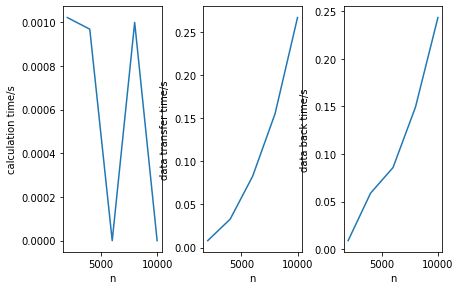

In [20]:
n = 200

SX = 32
SY = 32
block_rows = (n + 31) // SX
block_cols = (n + 31) // SY



nob = (len(u) + 1023) // 1024
rec = list()

# just change lim_h to a lower value if the current setting runs out of memory in your environment
lim_h = 12000
lim_l = 2000
lim_i = 2000


for n in range(lim_l, lim_h, lim_i):
    u = np.random.RandomState(0).rand(n,n).astype("float64")
    # res = np.zeros(u.shape, dtype=np.float64)
    with Timer() as t_data:
        u_cuda = numba.cuda.to_device(u)
        res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
    print("data transfer takes, {0:.5f} seconds, n = {a}".format(t_data.interval, a=n))
    with Timer() as t_cal:
        mat_A_cuda_shared[(block_rows, block_cols),(SX, SY)](u_cuda, res_cuda)
    print("calculation takes, {0:.5f} seconds, n = {a}".format(t_cal.interval, a=n))
    with Timer() as t_back:
        res_cuda = res_cuda.copy_to_host()
    print("data back takes, {0:.5f} seconds, n = {a}".format(t_back.interval, a=n))
    u_cuda = u_cuda.copy_to_host()
    rec.append({"n":n,"t_data":t_data.interval,"t_cal":t_cal.interval, "t_back":t_back.interval})

fig, _ = plt.subplots(1,3)
fig.tight_layout() 
axs1 = plt.subplot(1, 3, 1)
axs1.plot([temp["n"] for temp in rec], [temp["t_cal"] for temp in rec])
axs1.set_xlabel("n")
axs1.set_ylabel("calculation time/s")
axs2 = plt.subplot(1, 3, 2)
axs2.plot([temp["n"] for temp in rec], [temp["t_data"] for temp in rec])
axs2.set_xlabel("n")
axs2.set_ylabel("data transfer time/s")
axs3 = plt.subplot(1, 3, 3)
axs3.plot([temp["n"] for temp in rec], [temp["t_back"] for temp in rec])
axs3.set_xlabel("n")
axs3.set_ylabel("data back time/s")
plt.show()

benchmark is similar to the non-shared method